In [2]:
# imports
import sys
sys.path.append('../BioExp')
import keras
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pandas as pd
import os
import pickle

from keras.backend.tensorflow_backend import set_session
from BioExp.helpers.metrics import *
from BioExp.helpers.losses import *

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
# GPU setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

![network_used](./imgs/networks.jpg)


Causal analysis for deep learning provides us the information about how the information is flowing in the network, Providing glimpses into the internals of such a network to provide a *trace of its inference steps* [citep](holzinger2017we) would go at least some way to elucidating exactly how the network makes its decisions, providing a measure of legitimacy.

For a brain tumor segmentation model, such methods might provide details on how information flows through the model and how the model is organized. For example, it might help in understanding how the model represents goes about detecting tumors and all the concepts involved in it.

We implement our pipeline on three different 2D brain tumor segmentation models descibed above - a Unet model with a densenet121 encoder (Henceforth referred to as the DenseUnet) [citep](shaikh2017brain), a Unet model with a ResNet encoder (ResUnet) [citep](kermi2018deep), and a simple encoder-decoder network which has a similar architecture to the ResUnet but without skip or residual connections (SimUnet). All models were trained till convergence on the BraTS 2018 dataset [cite](menze2014multimodal). A held out validation set of 48 volumes (including both LGG and HGG volumes) was used for testing. Below table shows the performance of the three models on this test set.


| Model Type |     WT Dice | TC Dice  | ET Dice|
|------------|:------------|:---------|:-------|
| DenseUnet  |     0.830   | 0.760    | 0.685  |
| ResUnet    |     0.788   | 0.734    | 0.649  |
| SimUnet    |     0.743   | 0.693    | 0.523  |

These models are not meant to achieve state of the art performance. Instead, we aim to demonstrate our methods on a set of models with different structures commonly used for brain tumor segmentation and compare them to better understand the process they take to segment the tumors. In this primary study, we do not use 3D models, since the visualization and analysis of interpretability related metrics is simpler for 2D models. Also, it is not clear how some of our results would scale to 3D models and whether it would be possible to visualize these. For example, disentangled concepts observed by performing network dissection might not be meaningful when visualized slice wise and would have to be visualized in 3D. This and the related analysis poses an additional layer of difficulty. 

In [5]:
# model and parameter defn
# currently using simple U-net

seq_map = {'flair': 0, 't1': 1, 't2': 3, 't1c':2}
seq = 'flair'

model_path        = '../BioExp/saved_models/model_{}_scaled/model-archi.h5'.format(seq)
weights_path      = '../BioExp/saved_models/model_{}_scaled/model-wts-{}.hdf5'.format(seq, seq)

# layers_to_consider = ['conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6','conv2d_7', 'conv2d_8', 'conv2d_9',\
#                       'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16',\
#                        'conv2d_17','conv2d_18', 'conv2d_19', 'conv2d_20', 'conv2d_21']


layers_to_consider = ['conv2d_13', 'conv2d_15','conv2d_17', 'conv2d_19', 'conv2d_20', 'conv2d_21']

model = load_model(model_path, custom_objects={'gen_dice_loss':gen_dice_loss,
                                'dice_whole_metric':dice_whole_metric,
                                'dice_core_metric':dice_core_metric,
                                'dice_en_metric':dice_en_metric})
model.load_weights(weights_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 1)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 64)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 240, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 240, 240, 64)      256 

## Proposed method
![pipeline](./imgs/graph.png)
The above figure illustrates the framework proposed for interpretability of deep learning models. According to which the we

The proposed framework for understanding the deep learning models consists multiple steps, which consists (i) concept formation, (ii) concept significance analysis, (iii) concept identification, (iv) network formation, and (v) trail estimation. Above figure provides the detailed overview of the above framework.


![pipeline](./imgs/pipeline2.png)

### Concept Formation

It's observed that few weights are particularly responsible to detect/encode certain features in an image [cite](#). In this work we consider that assumption to group all the weights responsible to detect ceratin features. Group of all the weights responsible for a particular feature forms in an individual cluster, encoding a particular human understandable or non- understandable concept. Most of our further analysis considers these concepts at the core, this method of grouping weights makes causal inference more tractable in deep learning models. We make use of various standard clustering techniques to cluster network weights. 

For faster inference, we make layer selection as a hyperparameter, i.e we don't run inference on the entire network but select some layers and construct the causal links among the neurons between them. 

Let the trained network be $\Phi(W, X)$, and considered layers for analysis are $\{..., l-1, l, l+1, ... \}$. The clusters $\{C^l_p, C^l_q, C^l_r, ...\}$ are formed as a result of clustering weights at layer $l$ in network $\Phi$. 

Let $W = \{ w_1, w_2,..., w_n\}$, where $W\in\mathbb{R}^{3 \times 3 \times inc \times outc}$ and $w_i \in \mathbb{R}^{3 \times 3 \times inc}$, after vectorization $W \in \mathbb{R}^{9inc \times outc}$ and $w_i \in \mathbb{R}^{9inc \times 1}$. To increase the difference between two simialr weights we encode position information [cite](#) with weights $w_i = w_i + X$, where $X$ is a point on $X=Y$ in same vector space as $w_i$, encoding position information ensures higher distance between two vectors with similar intensity values but different orientation. Clusters are formed with respect to these modified weights, using hierarchical clustering method [cite](#) using distance based thresholding rather than fixing number of clusters. 

After obtaining the clusters weights are arranged accordingly to observe similarity among the clustered weights. Figure \ref{} depects the same. 



Similarly, such concepts are extracted from all the defined layers. 

Main challenge in generating these clusters is the dimensionality of these weights which easily $\supset \mathbb{R^{3\times 3 \times 32 }}$.  

First approach is to directly unroll these tensors and perform clustering. Fortunately even this provides some results which are very hard to interpret directly, but can be analysied by conducting further steps defined in above pipeline.

In [6]:
from BioExp.clusters import clusters

concept_info = []
node = 0

save_root = './Logs/{}/weights_cluster/'.format(seq)
for layer_name in layers_to_consider:
    save_path = os.path.join(save_root, layer_name)
    os.makedirs(save_path, exist_ok = True)
    
    C = clusters.Cluster(model, weights_path, layer_name)
    labels = C.get_clusters(threshold = 0.5, save_path=save_path)
    C.plot_weights(labels, os.path.join(save_path, 'wt-samples'))
    
    for label in np.unique(labels):
        nodename = 'node_{}'.format(node)
        layername = layer_name
        fidxs = np.where(labels==label)[0]
        info = {'concept_name': nodename, 
                  'layer_name': layername, 
                 'filter_idxs': fidxs}
        concept_info.append(info)
        node += 1
        
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'wb') as file:
    pickle.dump(concept_info, file)

[INFO: BioExp Clustering] Layer: conv2d_13, Nclusters: 5, Labels: [0 1 2 3 4], Freq. of each labels: [65, 72, 53, 38, 28]
[INFO: BioExp Clustering] Layer: conv2d_15, Nclusters: 6, Labels: [0 1 2 3 4 5], Freq. of each labels: [43, 88, 41, 32, 34, 18]
[INFO: BioExp Clustering] Layer: conv2d_17, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [72, 25, 31]
[INFO: BioExp Clustering] Layer: conv2d_19, Nclusters: 5, Labels: [0 1 2 3 4], Freq. of each labels: [23, 10, 17, 8, 6]
[INFO: BioExp Clustering] Layer: conv2d_20, Nclusters: 6, Labels: [0 1 2 3 4 5], Freq. of each labels: [17, 12, 10, 11, 8, 6]
[INFO: BioExp Clustering] Layer: conv2d_21, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [43, 15, 6]


----------
### TODO

Another proposed method for clustering is to hand-engineered features using statistical methods. We carefully select features responsible for orientations, intensity, and textures using statistical tricks, which are further used by GMM's for grouping them together. 

- [ ] Different clustering methods by hand engineered features
- [x] Features considered currently, which in combination provides transforms any weight tensor to vector $\in \mathbb{R}^{32\times 1}$
        - Orientation features
        - Energy features
        - Texture features

This method still needs some thoughts to make it work as expected, which will be explored in future works. As the clusters formed are still in expectational sense, which results in loss of information which inturn makes it hard to form well seperated clusters.

### Concept Identification

We use gradient based method to visualize and identify concepts

+ Generated multinomial distribution can be used as a proxy for each concepts
+ To verify that gaussian is not spread over, and has some nice range

Flow Identifier prints dice of the binarized concept with ground truth and also tries to estimate entropy

-----------------

#### GradCAM revist
![cam](./imgs/gradcam.png)


For concept identification, we use a gradient-based method to find the effective regions in an input image. Consider concept $C^l_p$, to identify the corrosponding region activated in an input image, we first modify the trained network by disecting the network at layer $l$, intervening the concepts other than $p$ to zeros i.e. $do(C^l_{-p} = 0)$, finally we adding $(1\times 1)$ convolution at the end, which results in $\Phi^{'}_{l}$. Adding $(1\times 1)$ convolution helps applying similat ideas of GradCAM [cite](#) as described bellow.

\begin{equation}
    y(l, k, x) = \dfrac{1}{P} \sum_{i} \sum_{j} \Phi^{'}_{l, k}(x) 
\end{equation}

\begin{equation}
    \beta(l, k, x) = \dfrac{1}{N}\sum_{i} \sum_{j} \dfrac{\partial y(l, k, x)} {\partial \Phi^{'ij}_{l, k}(x)}
\end{equation}
\begin{equation}
    Concept = \mathbb{E}_{k \sim fidxs_p} \left (ReLU\left ( \beta(l, k, x) \Phi^{'}_{l, k}(x) \right) \right)  
\end{equation}


Once when the concepts are identified, we conduct a significance analysis for each concept to make sure the concept selected is statistically significant in selecting the features. To accomplish the same, we first generate the distribution for each concept. As weights in the cluster are responsible for a particular concept, they can be considered are ergodic i.e. these weights can be considered as the outcome of same expirement on different trials [cite](#). Using this assumptions we consider all the weights in a particular cluster and generate a distribution with a gaussian prior.

Let $w \in C^l_p$ and $w \in \mathbb{R}^{3 x 3 x inc}$, we have such $n$ w's in a particular concept. The moment information of these samples are used to approximate the distribution to gaussian.
Obtained distribution $G(\mu, \sigma) = \sigma ^{-0.5} \exp \{- \frac{\mu^2}{\sigma ^2}\}$ where $\mu = \mathbb{E}(w)$ and $\sigma = \mathbb{E}(w - \mathbb{E}(w))$, the distribution here is in pixel space. 

Once when we have the distribution, we sample several concepts and run concept identification test to map the similarities between original and sampled concepts. One with higher variance with respect to an original concept is removed completely from further tests, as it doesn't coherently map to any concepts in an input image.

In [ ]:
from BioExp.clusters.concept import ConceptIdentification
from BioExp.helpers import utils

image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/Brats18_CBICA_AOP_1', slicen=105)
image = image[:, :, seq_map[seq]][:,:, None]

save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
metric = dice_label_coef # defined in helpers.losses
identifier = ConceptIdentification(model, weights_path, metric)

save_root = './Logs/{}/concept_identification'.format(seq)


resume_steps = ['conv2d_21']
for concept_info in concepts_info:   
    if not (concept_info['layer_name'] in resume_steps): continue
    identifier.flow_based_identifier(concept_info, 
                           save_path = os.path.join(save_root, 
                                                    concept_info['layer_name']), 
                           test_img = image)
    
    identifier.check_robustness(concept_info,
                            save_path = os.path.join(save_root, 
                                                     concept_info['layer_name']), 
                            test_img = image,
                            save_all = True,
                            nmontecarlo = 10)

=========./Logs/flair/concept_identification/conv2d_13/node_0.png========


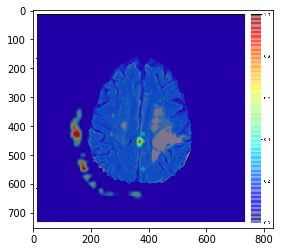

=========./Logs/flair/concept_identification/conv2d_13/node_1.png========


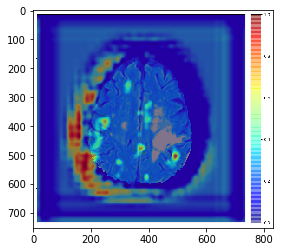

=========./Logs/flair/concept_identification/conv2d_13/node_2.png========


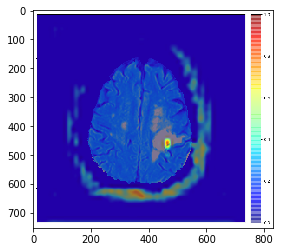

=========./Logs/flair/concept_identification/conv2d_13/node_3.png========


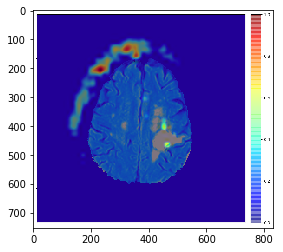

=========./Logs/flair/concept_identification/conv2d_13/node_4.png========


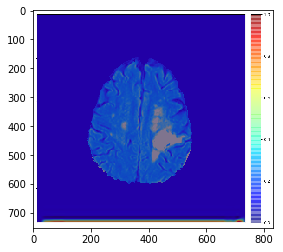

=========./Logs/flair/concept_identification/conv2d_15/node_10.png========


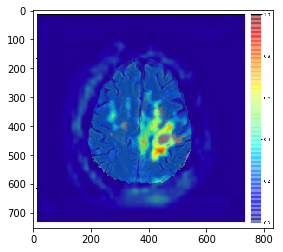

=========./Logs/flair/concept_identification/conv2d_15/node_5.png========


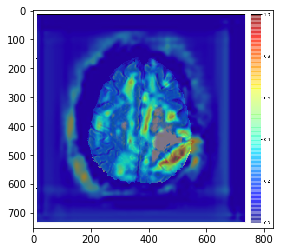

=========./Logs/flair/concept_identification/conv2d_15/node_6.png========


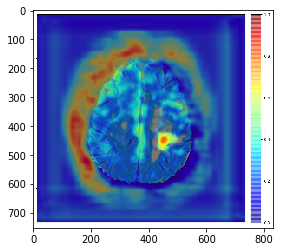

=========./Logs/flair/concept_identification/conv2d_15/node_7.png========


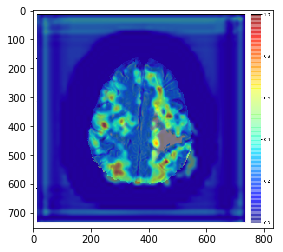

=========./Logs/flair/concept_identification/conv2d_15/node_8.png========


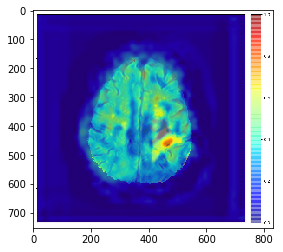

=========./Logs/flair/concept_identification/conv2d_15/node_9.png========


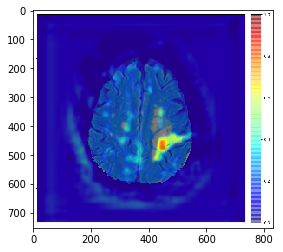

=========./Logs/flair/concept_identification/conv2d_17/node_11.png========


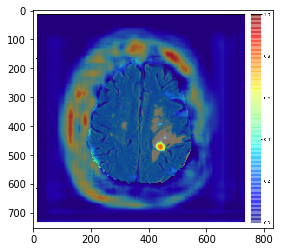

=========./Logs/flair/concept_identification/conv2d_17/node_12.png========


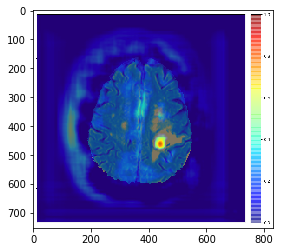

=========./Logs/flair/concept_identification/conv2d_17/node_13.png========


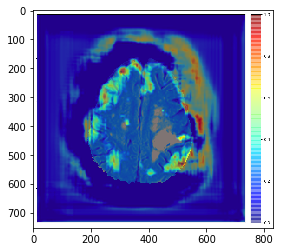

=========./Logs/flair/concept_identification/conv2d_19/node_14.png========


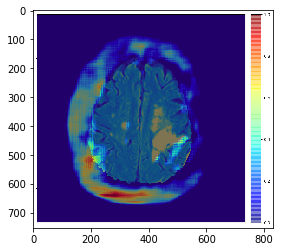

=========./Logs/flair/concept_identification/conv2d_19/node_15.png========


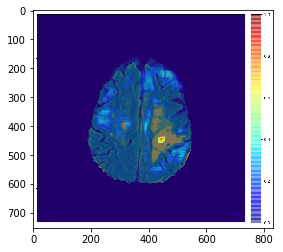

=========./Logs/flair/concept_identification/conv2d_19/node_16.png========


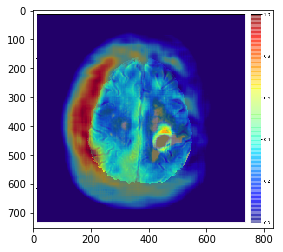

=========./Logs/flair/concept_identification/conv2d_19/node_17.png========


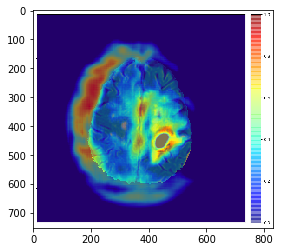

=========./Logs/flair/concept_identification/conv2d_19/node_18.png========


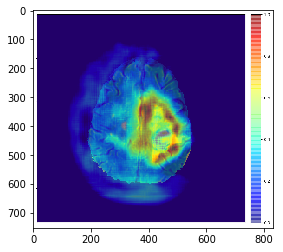

=========./Logs/flair/concept_identification/conv2d_20/node_19.png========


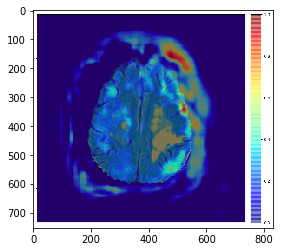

=========./Logs/flair/concept_identification/conv2d_20/node_20.png========


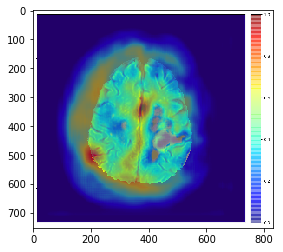

=========./Logs/flair/concept_identification/conv2d_20/node_21.png========


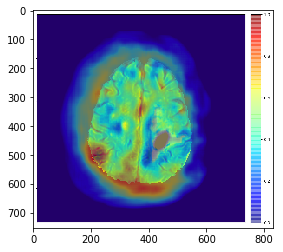

=========./Logs/flair/concept_identification/conv2d_20/node_22.png========


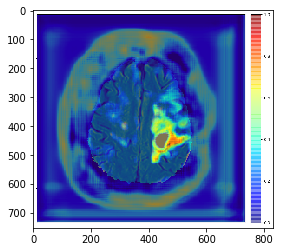

=========./Logs/flair/concept_identification/conv2d_20/node_23.png========


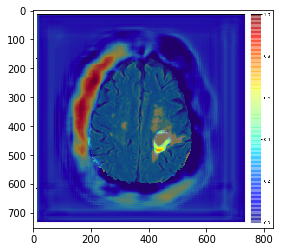

=========./Logs/flair/concept_identification/conv2d_20/node_24.png========


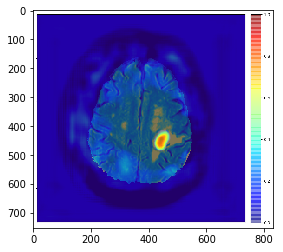

=========./Logs/flair/concept_identification/conv2d_21/node_25.png========


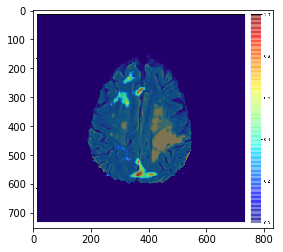

=========./Logs/flair/concept_identification/conv2d_21/node_26.png========


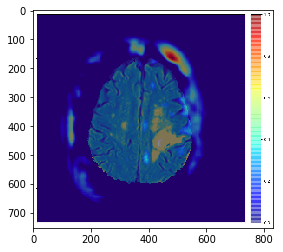

=========./Logs/flair/concept_identification/conv2d_21/node_27.png========


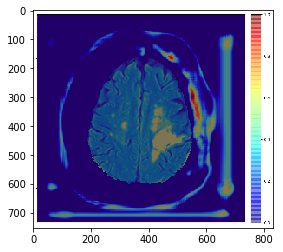

In [13]:
from glob import glob
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

save_root = './Logs/{}/concept_identification'.format(seq)
paths = np.array([pth for pth in glob(save_root + '/*/*.png') if not pth.__contains__('robustness')])
for pth in paths:
    print ("========={}========".format(pth))
    plt.imshow(np.array(Image.open(pth)))
    plt.show()


=========./Logs/flair/concept_identification/conv2d_13/node_0_robustness.png========


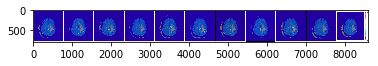

=========./Logs/flair/concept_identification/conv2d_13/node_1_robustness.png========


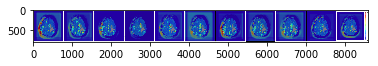

=========./Logs/flair/concept_identification/conv2d_13/node_2_robustness.png========


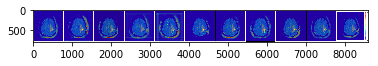

=========./Logs/flair/concept_identification/conv2d_13/node_3_robustness.png========


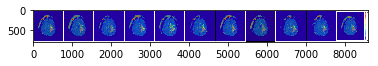

=========./Logs/flair/concept_identification/conv2d_13/node_4_robustness.png========


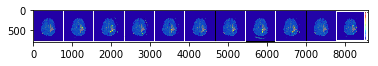

=========./Logs/flair/concept_identification/conv2d_15/node_10_robustness.png========


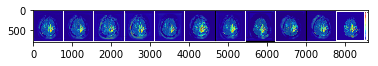

=========./Logs/flair/concept_identification/conv2d_15/node_5_robustness.png========


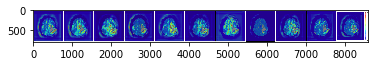

=========./Logs/flair/concept_identification/conv2d_15/node_6_robustness.png========


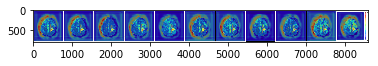

=========./Logs/flair/concept_identification/conv2d_15/node_7_robustness.png========


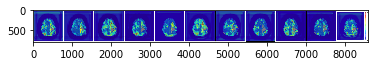

=========./Logs/flair/concept_identification/conv2d_15/node_8_robustness.png========


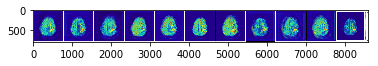

=========./Logs/flair/concept_identification/conv2d_15/node_9_robustness.png========


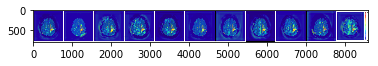

=========./Logs/flair/concept_identification/conv2d_17/node_11_robustness.png========


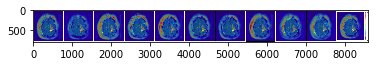

=========./Logs/flair/concept_identification/conv2d_17/node_12_robustness.png========


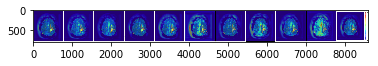

=========./Logs/flair/concept_identification/conv2d_17/node_13_robustness.png========


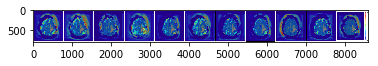

=========./Logs/flair/concept_identification/conv2d_19/node_14_robustness.png========


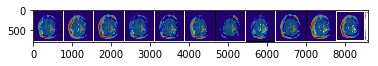

=========./Logs/flair/concept_identification/conv2d_19/node_15_robustness.png========


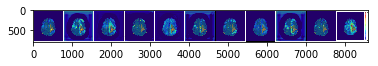

=========./Logs/flair/concept_identification/conv2d_19/node_16_robustness.png========


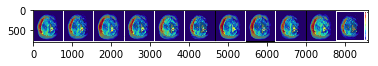

=========./Logs/flair/concept_identification/conv2d_19/node_17_robustness.png========


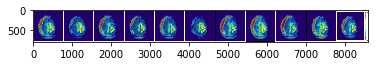

=========./Logs/flair/concept_identification/conv2d_19/node_18_robustness.png========


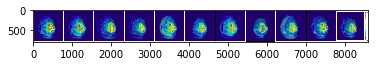

=========./Logs/flair/concept_identification/conv2d_20/node_19_robustness.png========


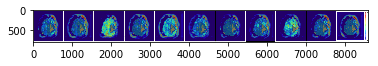

=========./Logs/flair/concept_identification/conv2d_20/node_20_robustness.png========


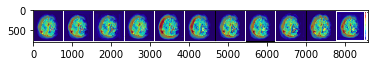

=========./Logs/flair/concept_identification/conv2d_20/node_21_robustness.png========


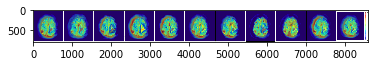

=========./Logs/flair/concept_identification/conv2d_20/node_22_robustness.png========


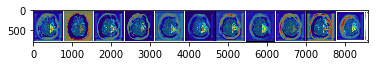

=========./Logs/flair/concept_identification/conv2d_20/node_23_robustness.png========


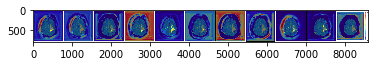

=========./Logs/flair/concept_identification/conv2d_20/node_24_robustness.png========


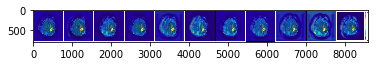

=========./Logs/flair/concept_identification/conv2d_21/node_25_robustness.png========


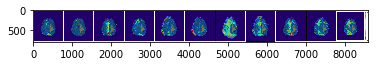

=========./Logs/flair/concept_identification/conv2d_21/node_26_robustness.png========


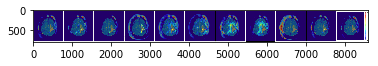

=========./Logs/flair/concept_identification/conv2d_21/node_27_robustness.png========


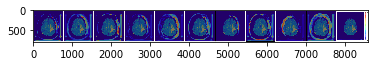

In [10]:
# Concept Robustness results

from glob import glob
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

save_root = './Logs/{}/concept_identification'.format(seq)
paths = np.array([pth for pth in glob(save_root + '/*/*.png') if pth.__contains__('robustness')])
for pth in paths:
    print ("========={}========".format(pth))
    plt.imshow(np.array(Image.open(pth)))
    plt.show()

In [6]:
# These descriptions are provided manually by the user, based on the way he/she interprets above images

from pprint import pprint
consider_nodes = [{'node': 0, 'description': 'Left Lower Brain boundary'}, 
                  {'node': 1, 'description': 'Left Brain boundary'}, 
                  {'node': 2, 'description': 'Right Brain boundary'},
                  {'node': 3, 'description': 'Upper Brain boundary'},
                  {'node': 5, 'description': 'Right Lower tumor boundary (outside)'},
                  {'node': 6, 'description': 'Brain boundary and tumor core'},
                  {'node': 7, 'description': 'Tumor half of the brain'},
                  {'node': 8, 'description': 'Right lower tumor boundary (inside)'},
                  {'node': 9, 'description': 'Right lower tumor boundary (inside)'},
                  {'node': 11, 'description': 'Brain boundary and tumor core'},
                  {'node': 12, 'description': 'Tumor Core'},
                  {'node': 13, 'description': 'Right Brain Boundary (tumor side)'},
                  {'node': 17, 'description': 'Tumor core Boundary and left brain boundary (opposite to tumor)'},
                  {'node': 18, 'description': 'Tuomr'},
                  {'node': 22, 'description': 'Tuomr core boundary (fine)'},
                  {'node': 24, 'description': 'Tumor core'}]

# update cluster info
save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
modified_concepts = []
for concept_info in concepts_info:
    for i, node in enumerate(consider_nodes):
        if node['node'] == int(concept_info['concept_name'].split('_').pop()):
            concept_info['description'] = consider_nodes[i]['description']
            pprint(concept_info)
            modified_concepts.append(concept_info)
            break

with open('./Logs/{}/modified_clusters.cpickle'.format(seq), 'wb') as file:
    pickle.dump(modified_concepts, file)  

{'concept_name': 'node_0',
 'description': 'Left Lower Brain boundary',
 'filter_idxs': array([  1,   5,   9,  11,  13,  24,  29,  33,  34,  36,  39,  41,  44,
        57,  60,  63,  66,  71,  73,  75,  81,  83,  89,  93,  96,  97,
       103, 104, 109, 111, 113, 114, 124, 128, 131, 137, 138, 144, 148,
       152, 153, 158, 160, 167, 171, 173, 174, 181, 183, 186, 189, 191,
       193, 196, 197, 199, 208, 211, 214, 226, 228, 239, 240, 242, 246]),
 'layer_name': 'conv2d_13'}
{'concept_name': 'node_1',
 'description': 'Left Brain boundary',
 'filter_idxs': array([  3,   7,   8,  10,  14,  17,  19,  22,  25,  27,  28,  40,  42,
        43,  48,  56,  58,  61,  65,  72,  76,  78,  79,  80,  84,  86,
        90,  94, 105, 107, 112, 115, 117, 121, 125, 130, 135, 143, 151,
       157, 164, 165, 168, 169, 170, 175, 176, 177, 178, 180, 184, 190,
       194, 195, 202, 204, 210, 215, 216, 221, 223, 227, 229, 231, 232,
       233, 241, 244, 248, 249, 250, 254]),
 'layer_name': 'conv2d_13'}
{'concep

----------

### Causal Graph Links


![causallinkage](./imgs/causality_linkage.png)

Based on information flow and divergance properties, still the network in correlation but the constraints imposed pushes correlation towards causality.

After the estimation of a significant concept, the next step is to construct the graph using these concepts, which kind captures causal interactions between the concepts. To construct this graph, we work with feature map distributions; mathematically, the link between any two concept nodes exists only if $MI$ (Mutual Information) is greater than a threshold value, which is described in bellow equations.

Let, $C_i^l$ denotes the $i^{th}$ concept in layer $l$. The directed link $C_i^p \rightarrow C_j^q$ is determined by $MI(\mathbb{Q}(x~|~\Phi_{j,q}), \mathbb{Q}(x~|~\Phi_{q}))$, where $\mathbb{Q}$ is the distribution of feature maps obtained by considering network $\Phi$. $\mathbb{Q}(x~|~\Phi_{j,q})$ is the distribution of feature maps generated as a result of considering just single concept $C_j^q$, while $\mathbb{Q}(x~|~\Phi_{q})$ is the distribution generated by considering all the concepts in layer $q$ and setting all $C_{-i}^p$ to zeros.

The directed link $C_i^p \rightarrow C_j^q$, exists only if $MI(\mathbb{Q}(x~|~\Phi_{j,q}), \mathbb{Q}(x~|~\Phi_{q})) > T$ where T is the threshold parameter. In terms of interventions link exists if 

$$MI(C_j^q, ~do(C_i^p = 1) ~|~ do(C_{-i}^p = 0), ~do(C_{-j}^q = 0)) - MI(C_j^q, ~do(C_i^p = 0) ~|~ do(C_{-i}^p = 0), ~do(C_{-j}^q = 0)) > T$$
$$\Rightarrow MI(C_j^q, ~do(C_i^p = 1) ~|~ do(C_{-i}^p = 0), ~do(C_{-j}^q = 0)) > T$$
because of the architecture design (no recurrent connection and skip links) 


In [ ]:
from BioExp.graphs.causal import CausalGraph
from BioExp.helpers import utils

metric = dice_label_coef # defined in helpers.losses
CG = CausalGraph(model, weights_path, metric)


with open('./Logs/{}/modified_clusters.cpickle'.format(seq), 'rb') as file:
    concept_info = pickle.load(file)

dataset_path = '../BioExp/sample_vol/brats/'
def dataloader(nslice = 78):
    def loader(img_path):
        image, gt =  utils.load_vol_brats(img_path, slicen=nslice)
        return image[:, :, seq_map[seq]][:,:, None], gt
    return loader

save_path = './Logs/{}/Graphs/causal'.format(seq)
os.makedirs(save_path, exist_ok=True)
CG.generate_graph(concept_info, 
                  dataset_path, 
                  dataloader(), 
                  edge_threshold = 0.5, 
                  save_path = save_path, 
                  max_samples=10)

In [6]:
import pickle

graph_path = './Logs/{}/Graphs/causal/causal_graph.pickle'.format(seq)
with open(graph_path, 'rb') as file:
    graph_json = pickle.load(file)

root_node = graph_json['rootNode']
graph = graph_json['graph']

graph.print(root_node)

node: Input, children: ['node_0', 'node_1', 'node_2', 'node_3'], parents: []
node: node_0, children: ['node_6', 'node_11', 'node_12', 'node_13', 'node_22'], parents: ['Input']
node: node_1, children: ['node_6', 'node_7', 'node_8', 'node_11', 'node_12', 'node_13', 'node_17', 'node_22'], parents: ['Input']
node: node_2, children: ['node_5', 'node_6', 'node_7', 'node_11', 'node_12', 'node_13'], parents: ['Input']
node: node_3, children: ['node_5', 'node_6', 'node_11', 'node_12', 'node_13', 'node_22'], parents: ['Input']
node: node_6, children: ['node_11', 'node_12', 'node_13'], parents: ['node_0', 'node_1', 'node_2', 'node_3']
node: node_11, children: ['node_22'], parents: ['node_0', 'node_1', 'node_2', 'node_3', 'node_5', 'node_6', 'node_7', 'node_8']
node: node_12, children: ['node_17'], parents: ['node_0', 'node_1', 'node_2', 'node_3', 'node_5', 'node_6', 'node_7', 'node_8']
node: node_13, children: [], parents: ['node_0', 'node_1', 'node_2', 'node_3', 'node_5', 'node_6', 'node_7', 'no

In [12]:
from BioExp.graphs.trails import EstimateTrails
from BioExp.helpers import utils

image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/Brats18_CBICA_ASA_1', slicen=92)
image = image[:, :, seq_map[seq]][:,:, None]
    
metric = dice_label_coef # defined in helpers.losses
GT = EstimateTrails(model, weights_path, graph, root_node, metric)

save_path = './Logs/{}/Graphs/trails'.format(seq)
tr, td, V = GT.trails('Input', 'node_22', image, gt, save_path=save_path, visual=True)


[INFO: BioExp Concept Identification] Identified Concept node_0 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_6 in layer conv2d_15
[INFO: BioExp Concept Identification] Identified Concept node_11 in layer conv2d_17
[INFO: BioExp Concept Identification] Identified Concept node_22 in layer conv2d_20
[INFO: BioExp Trails]===== New trail =====
  (Input)  ->  (node_0)  ->  (node_6)  ->  (node_11)  ->  (node_22)  
  (Input Image to a network)  ->  (Left Lower Brain boundary)  ->  (Brain boundary and tumor core)  ->  (Brain boundary and tumor core)  ->  (Tuomr core boundary (fine))  


# references

do-Calculus
+ https://ftp.cs.ucla.edu/pub/stat_ser/r402.pdf
+ https://plato.stanford.edu/entries/causal-models/do-calculus.html
+ https://arxiv.org/pdf/1305.5506.pdf

Graphs
+ KF ch1 to ch3